<center>Курсова робота<br>Трипадуша Богдана Івановича<br>201-Б групи<br>Спеціальності "Комп'ютерні науки"

# Підготовка даних

&emsp;Нам надані два набори даних пов’язані з червоним і білим варіантами португальського вина «Vinho Verde». Через проблеми конфіденційності та логістики доступні лише фізико-хімічні (вхідні) та сенсорні (вихідні) змінні (наприклад, немає даних про типи винограду, бренд вина, ціну продажу вина тощо).

&emsp;Метою нашої роботи є визначити, яка з моделей задач класифікації та регресії буде робити найкращі передбачення. Отож, почнемо з підготовки бібліотек, необхідних для нашої роботи:

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense

results = []


&emsp;Переглянемо перші 10 рядків наших даних, щоб мати уявлення, із чим ми маємо справу та переконатися, що данні успішно зчитані з файлу:

In [105]:
redWine = pd.read_csv('winequality-red.csv', sep=';')
whiteWine = pd.read_csv('winequality-white.csv', sep=';')

wine = pd.concat([redWine, whiteWine])

wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


&emsp;&emsp;Щоб бути впевненим в подальших дослідженнях, переконуємося, що у всіх стопцях відсутні порожні значення:

In [84]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9 KB


&emsp;&emsp;З інформації вище, можемо визначити, що якість вин (quality) є дискретним типом даних, оскільки використовує обмеженний радіус чисел int64, у той щас як решта є неперервиними. Сенсу в подальшій обробці даних не має.

&emsp;Почнемо з простими порівняннями між білими та червоними винами. За діаграмою нижче, можемо спостерігати співвідношення між видами вин. Хороших, як і жахливих за якістю вин нещадно мало, їх тяжко помітити, але у співвідношенні можемо спостерігати, що білі вина в середньому кращі за якістю, ніж червоні.

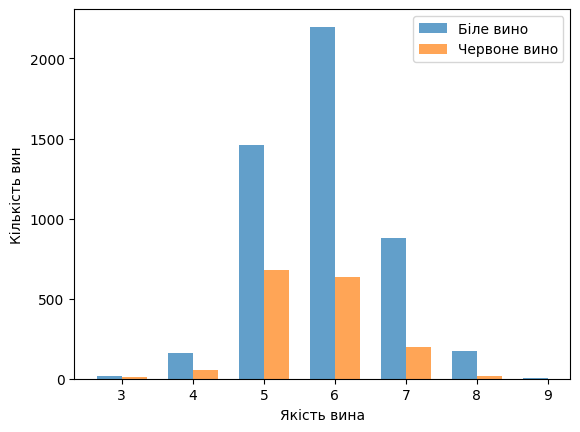

In [107]:
red_counts = redWine['quality'].value_counts().sort_index()
white_counts = whiteWine['quality'].value_counts().sort_index()

bar_width = 0.35

bar_positions_white = np.arange(len(white_counts))
bar_positions_red = np.arange(len(red_counts)) + bar_width

fig, ax = plt.subplots()

ax.bar(bar_positions_white, white_counts, label='Біле вино', width=bar_width, alpha=0.7)
ax.bar(bar_positions_red, red_counts, label='Червоне вино', width=bar_width, alpha=0.7)

plt.xlabel('Якість вина')
plt.ylabel('Кількість вин')
plt.xticks(bar_positions_white + bar_width / 2, [str(x) for x in range(3, 10)])
plt.legend()

plt.show()


&emsp;&emsp;Дослідимо зв'язок між змінними у наших данних через матрицю кореляції:

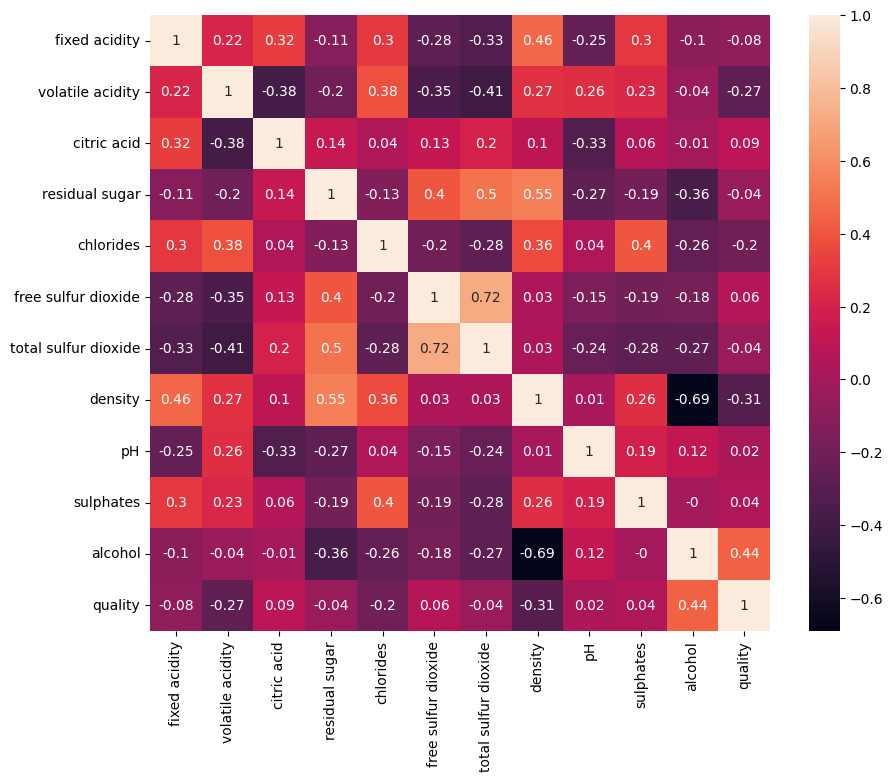

In [86]:
corr_mat_wine = wine.corr().round(2)
plt.figure(figsize = (10, 8))
plot = sns.heatmap(corr_mat_wine, annot = True)


Зробимо декілька поверхових висновків стосовно зображення вище:<br>
<ul>
    <li>Коефіцієнт 0.44 між якістю вина та вмістом алкоголя свідчить про помірну позитивну кореляцію між цими двома змінними. Тобто, зі зростанням вмісту алкоголю частіше спостерігається підвищення якості вина.</li>
    <li>Коефієнт -0.69 між вмістом алкоголю та щільністю вказує, що при збільшенні вмісту алкоголю, зменшується щільність вина.</li>
    <li>Кореляція між щільністю вина та кислотністю, з коефіцієнтом 0.46, вказує на те, що разом з рівнем кислотності, зростає і щільність.</li>
</ul>

# Моделі

<h3>Лінійна регресія</h3>

&emsp;Всі данні успішно підготовлені, можемо бути впевненими, що ніякиї підводних каменів не має. Тому, наступним кроком ми приступаємо до навачання та оцінки моделей, і почнеми з лінійної регресії:

In [87]:
X = wine.drop('quality', axis=1) 
y = wine['quality']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_res, test_res = [], []

for train_idx, test_idx in kf.split(X, y):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    
    y_train_preds, y_test_preds = model.predict(X_train), model.predict(X_test)
    
    train_res.append(np.round(mean_squared_error(y_train, y_train_preds), 2))
    test_res.append(np.round(mean_squared_error(y_test, y_test_preds), 2))

results.append({"method": "Лінійна регресія", "train_error": sum(train_res)/len(train_res), "test_error": sum(test_res)/len(test_res)})

print('Помилки на навчальних наборах: ', train_res)
print('Помилки на тестових наборах: ', test_res)

Помилки на навчальних наборах:  [0.54, 0.54, 0.54, 0.54, 0.54]
Помилки на тестових наборах:  [0.55, 0.54, 0.53, 0.55, 0.54]


&emsp;&emsp;З отриманих результатів можна зробити виснвоок, що модель має приблизно однакові значення помилки на навчальних та тестових наборах, що може свідчити про те, що модель не страждає від перенавчання або недонавчання.

&emsp;&emsp;Ключовий аспект полягає в тому, що помилки на навчальних і тестових наборах приблизно рівні (в даному випадку, вони практично однакові). Це може означати, що модель є достатньо простою або, навпаки, що дані можуть бути надто простими для моделі, і вона не може адекватно наблизити їх.

<h3>Дерево рішень</h3>

Наступним кркоом розглянемо дерево рішень:

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_tree = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=2,
    min_samples_split=10,
    min_samples_leaf=5
).fit(X_train, y_train)

y_pred_train = reg_tree.predict(X_train)
y_pred_test = reg_tree.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Помилка на навчальних наборах:", mse_train)
print('Помилка тестових даних:', mse_test)


Помилка на навчальних даних: 0.5808403653952521
Помилка тестових даних: 0.5893611011213997


&emsp;&emsp;Спостерігаємо, що помилки грубші, ніж при лінійній регресії. Пропоную не відкидувати одразу дерево рішень та спробувати погратися з заданням глибини:

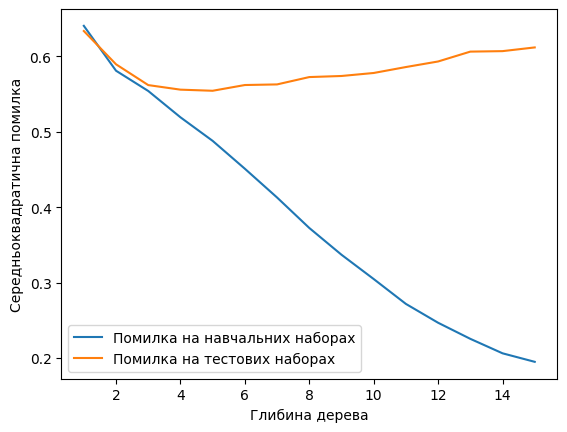

In [89]:
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_errors = []
test_errors = []
minTestError = 100
minTrainError = 100
depthWithMinError = 1

for depth in range(1, 16):
    reg_tree = DecisionTreeRegressor(
        criterion='squared_error',
        max_depth=depth,
        min_samples_split=10,
        min_samples_leaf=5
    ).fit(X_train, y_train)

    y_pred_train = reg_tree.predict(X_train)
    y_pred_test = reg_tree.predict(X_test)

    trainMSE = mean_squared_error(y_train, y_pred_train)
    testMSE = mean_squared_error(y_test, y_pred_test)

    train_errors.append(trainMSE)
    test_errors.append(testMSE)
    
    if testMSE < minTestError and trainMSE < minTrainError:
        minTestError = testMSE
        minTrainError = trainMSE
        depthWithMinError = depth


results.append({"method": "Дерево рішень", "train_error": minTrainError, "test_error": minTestError})

plt.plot(range(1, 16), train_errors, label='Помилка на навчальних наборах')
plt.plot(range(1, 16), test_errors, label='Помилка на тестових наборах')
plt.xlabel('Глибина дерева')
plt.ylabel('Середньоквадратична помилка')
plt.legend()
plt.show()


In [90]:
print("При глибині:", depthWithMinError)
print("Помилка на навчальних наборах:", minTrainError)
print("Помилка на тестових наборах:", minTestError)

При глибині: 5
Помилка на навчальних наборах: 0.4878398798548822
Помилка на тестових наборах: 0.5542661574325674


&emsp;Таким чином, ми бачимо, що дерево рішень дає цікавіші та різноманітніші результати, ніж лінійна регресія. При збільшенні глибини, згідно графіку, помилка на навчальних наборах значно падає, у той час як на тестових по-трохи зростає. Щоб не загромаджувати красу нашої роботи, я вручну погрався зі змінною параметрів <em>min_samples_split</em> та <em>min_samples_leaf</em>, однак вони не так впливали на результати, як зміна глибини.

<h3>Bagging</h3>

&emsp;Пропоную не відходити далеко від дерев рішень, та скористатися бегінгом (bagging). Основна ідея бегінга полягає в тому, щоб побудувати кілька однакових моделей на випадковій вибірці даних, а потім усереднити їх прогнози. Дані можуть повторюватися у різних моделях.

In [91]:
rf_model = RandomForestRegressor(
    n_estimators=80,
    criterion='squared_error',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Бегінг", "train_error": mse_train, "test_error": mse_test})

print('Помилка на тренувальних даних:', mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на тренувальних даних: 0.4541247753281817
Помилка на тестових даних: 0.6117288236179013


&emsp;Покращення виникає завдяки тому, що моделі у бегінгу навчаються на випадкових підмножинах даних, що робить їх більш незалежними. Шляхом обчислення середнього значення прогнозів моделей, помилка однієї моделі може бути скомпенсована більш вдалим прогнозом іншого. Це призводить до отримання більш стабільних і часто точних результатів.

<h3>Boosting</h3>

&emsp;Бустинг — це ще один "дерев'яний" алгоритм. Ідея бустінгу подібна до ідеї бегінгу у тому, що в обидвіх випадках формується ансамбль моделей, де кожна модель має невелику точність сама по собі, але разом вони дозволяють досягти високого результату.

&emsp;Втім, в той час як у бегінгу всі моделі будуються абсолютно незалежно одна від одної (на трохи різних даних, щоб різні учасники ансамблю не були абсолютно ідентичними), бустінг використовує відмінний підхід. Кожна наступна модель у бустінгу будується так, щоб скоригувати помилки всіх попередніх моделей. Бустінг отримав найбільшу популярність у поєднанні з деревами класифікації та регресії, що і підходить до нашого "винного" датасету.

&emsp;Пропоную розібрати найпоширеніший вид варіант бустінгу — градієнтний:

In [92]:
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

xgboost_model.fit(X_train, y_train)

y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Бустінг", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на навчальних даних: 0.40644928292380494
Помилка на тестових даних: 0.4636099128601301


Якщо задати максимальну глибину саме 3, то серед усіх трьох способів він дасть найменшу похибку, при тому, що вираховується моментально.

<h3>Метод опорних векторів</h3>

&emsp;Я би надав перевагу почати наше дослідження методу опорних векторів з лінійного методу, але оскільки повний розбір нашого датасету займає довгий час, то ми скоротимо данні вдвічі, задавши <em>train_size = 0.5</em>.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.5, random_state=42)

svm_model = SVR(kernel='linear')

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Лін. метод опорних векторів", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на навчальних даних: 0.5490380054471885
Помилка на тестових даних: 0.5546603974281986


&emsp;Результати, як ми бачимо, доволі помірні та майже нічим не відрізняються від досліджень із лінійною регресією. Знову взявши за основу цілий датасет, спробуємо поліноміальне ядро:

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = SVR(kernel='poly')

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Поліном. метод опорних векторів", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Помилка на навчальних даних: 0.6895865769360924
Помилка на тестових даних: 0.7911387595247017


&emsp;Та радіальне базисне ядро:

In [95]:
svm_model = SVR(kernel='rbf')

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Метод RBF опорних векторів", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)

Помилка на навчальних даних: 0.6375598652800638
Помилка на тестових даних: 0.6336029703067066


&emsp;На жаль, лишень лінійний метод цієї моделі видає втішні результати, решта заставляє бажати кращого.

<h3>Нейромережа</h3>

&emsp;На останок, я вирішив притягнути нейромережі до наших дослджень, а саме Keras. Вони мають певну перевагу над методами, що ми використовували до цього, а саме вони мають здатність виявляти складні залежності та автоматично вчитися ваги із навчальних даних, адаптуючись до особливостей конкретного набору даних.

&emsp;Однак, вони потребують велику кількість данних для кращих результатів, що може погано зіграти з нашими даними.

In [96]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

results.append({"method": "Нейромережа Keras", "train_error": mse_train, "test_error": mse_test})

print("Помилка на навчальних наборах:", mse_train)
print("Помилка на тестових наборах:", mse_test)


Epoch 1/50
130/130 - 1s - loss: 28.7007 - val_loss: 0.9401 - 1s/epoch - 10ms/step
Epoch 2/50
130/130 - 0s - loss: 0.7839 - val_loss: 0.6754 - 323ms/epoch - 2ms/step
Epoch 3/50
130/130 - 0s - loss: 0.6742 - val_loss: 0.6182 - 443ms/epoch - 3ms/step
Epoch 4/50
130/130 - 0s - loss: 0.6371 - val_loss: 0.5812 - 379ms/epoch - 3ms/step
Epoch 5/50
130/130 - 0s - loss: 0.6182 - val_loss: 0.5836 - 323ms/epoch - 2ms/step
Epoch 6/50
130/130 - 0s - loss: 0.6235 - val_loss: 0.5591 - 340ms/epoch - 3ms/step
Epoch 7/50
130/130 - 0s - loss: 0.6127 - val_loss: 0.5743 - 260ms/epoch - 2ms/step
Epoch 8/50
130/130 - 0s - loss: 0.5863 - val_loss: 0.5527 - 298ms/epoch - 2ms/step
Epoch 9/50
130/130 - 0s - loss: 0.6065 - val_loss: 0.5978 - 299ms/epoch - 2ms/step
Epoch 10/50
130/130 - 0s - loss: 0.5859 - val_loss: 0.5446 - 265ms/epoch - 2ms/step
Epoch 11/50
130/130 - 0s - loss: 0.5866 - val_loss: 0.5583 - 236ms/epoch - 2ms/step
Epoch 12/50
130/130 - 0s - loss: 0.5747 - val_loss: 0.5430 - 313ms/epoch - 2ms/step
Ep

Схоже, у наших обчисленях роль зіграли деякі нюанси, і обчислення були прораховані гірше, ніж у більшості моделей.

# Висновок

&emsp;У нашому дослідженні ми використали кілька моделей для прогнозування якості вин Vinho Verde. Почали ми з лінійної регресії, яка показала дуже добрі результати і є найкращою моделлю, якщо нашою метою є мінімізація різниці між тестовими та навчальними даними.

&emsp;Далі ми використали дерева рішень. Вони можуть бути використані, якщо нам припустиме збільшення різниці між тестовими та навчальними даними. Використання методу бегінгу покращило результати ще більше, підвищуючи стійкість та точність моделі. Застосування методу бустингу також показало добрі результати, зокрема, якщо правильно підібрати параметри, вони можуть перевершити інші "дерев'яні" моделі.

&emsp;Метод опорних векторів (SVM) не виявився так ефективним у нашому випадку. Лише лінійне ядро показало прийнятні результати, але враховуючи великий час обчислень, цей метод не став оптимальним вибором.

&emsp;Нейромережі, на жаль, не продемонстрували вражаючих результатів на нашому наборі даних, що може бути пов'язано з його особливостями.

&emsp;У підсумку, лінійна регресія та метод бустінгу є нашими перевагами у контексті даного дослідження, що продемонстровано на діаграмі нижче.

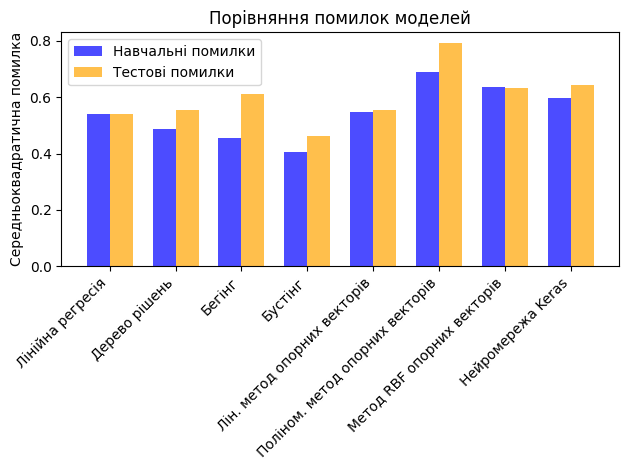

In [104]:
methods = [result['method'] for result in results]
train_errors = [result['train_error'] for result in results]
test_errors = [result['test_error'] for result in results]

width = 0.35  

x = np.arange(len(methods))  

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, train_errors, width, label='Навчальні помилки', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, test_errors, width, label='Тестові помилки', color='orange', alpha=0.7)

ax.set_ylabel("Середньоквадратична помилка")
ax.set_title("Порівняння помилок моделей")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right') 
ax.legend()

fig.tight_layout()

plt.show()


---
# <center> **Дякую за увагу!**</center>
---
